# Phase 4: Inference & Deployment
## Weakly Supervised Video Anomaly Detection - Model Inference Pipeline

This notebook implements Phase 4: Using the trained MIL model for inference on new videos.

### Pipeline Overview:
1. **Load Trained Model** - Load the best model from Phase 3
2. **Video Processing Pipeline** - Process new videos for inference
3. **Feature Extraction** - Extract TimeSformer features from new videos
4. **Segment-level Inference** - Get anomaly scores per segment
5. **Frame-level Anomaly Scores** - Map segment scores to frame-level
6. **Visualization** - Visualize anomaly detection results
7. **Batch Inference** - Process multiple videos at once
8. **Export Results** - Save detection results for analysis

### Expected Input:
- Trained MIL model from Phase 3
- New video files for anomaly detection

### Expected Output:
- Frame-level anomaly scores
- Anomaly detection visualizations
- Detection reports and statistics

## Section 1: Environment Setup & Model Loading

In [1]:
"""
Phase 4: Inference & Deployment
Environment Setup and Model Loading
"""

import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from typing import List, Dict, Optional, Tuple, Union
import json
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import warnings
warnings.filterwarnings('ignore')

# ==================== GPU Setup ====================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🎯 Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")

🎯 Using device: cuda
   GPU: NVIDIA GeForce RTX 3080 Ti
   Memory: 12.00 GB


In [2]:
"""
Configuration for Phase 4: Inference
"""

# ==================== Paths ====================
DATASET_ROOT = r"C:\UCF_video_dataset"
MODELS_PATH = os.path.join(DATASET_ROOT, "MIL_Models")
FEATURES_PATH = os.path.join(DATASET_ROOT, "TimeSformer_Features")
INFERENCE_OUTPUT_PATH = os.path.join(DATASET_ROOT, "Inference_Results")

# ==================== Model Parameters (Must match Phase 3) ====================
FEATURE_DIM = 768
HIDDEN_DIM_1 = 512
HIDDEN_DIM_2 = 128
DROPOUT_RATE = 0.6
TOP_K = 3
NUM_SEGMENTS = 16

# ==================== Inference Parameters ====================
ANOMALY_THRESHOLD = 0.5  # Threshold for binary anomaly classification
SMOOTHING_SIGMA = 2  # Gaussian smoothing for temporal consistency

# Create output directory
os.makedirs(INFERENCE_OUTPUT_PATH, exist_ok=True)

print("\n" + "="*70)
print("PHASE 4 CONFIGURATION (INFERENCE)")
print("="*70)
print(f"\n📁 Paths:")
print(f"   Models: {MODELS_PATH}")
print(f"   Output: {INFERENCE_OUTPUT_PATH}")
print(f"\n🔢 Model Parameters:")
print(f"   Feature Dim: {FEATURE_DIM}")
print(f"   Hidden Dims: {HIDDEN_DIM_1} → {HIDDEN_DIM_2}")
print(f"   Top-k: {TOP_K}")
print(f"   Segments: {NUM_SEGMENTS}")
print(f"\n⚙️  Inference Settings:")
print(f"   Anomaly Threshold: {ANOMALY_THRESHOLD}")
print(f"   Smoothing Sigma: {SMOOTHING_SIGMA}")
print("="*70)


PHASE 4 CONFIGURATION (INFERENCE)

📁 Paths:
   Models: C:\UCF_video_dataset\MIL_Models
   Output: C:\UCF_video_dataset\Inference_Results

🔢 Model Parameters:
   Feature Dim: 768
   Hidden Dims: 512 → 128
   Top-k: 3
   Segments: 16

⚙️  Inference Settings:
   Anomaly Threshold: 0.5
   Smoothing Sigma: 2


## Section 2: MIL Network Architecture (Same as Phase 3)

We need to define the same architecture to load the trained weights.

In [3]:
"""
MIL Network Architecture (Must match Phase 3 exactly)
"""

class MILNetwork(nn.Module):
    """
    Multiple Instance Learning Network for Video Anomaly Detection.
    Architecture: 768 → 512 → 128 → 1
    """
    
    def __init__(
        self,
        feature_dim: int = FEATURE_DIM,
        hidden_dim_1: int = HIDDEN_DIM_1,
        hidden_dim_2: int = HIDDEN_DIM_2,
        dropout_rate: float = DROPOUT_RATE,
        top_k: int = TOP_K
    ):
        super(MILNetwork, self).__init__()
        
        self.top_k = top_k
        
        # Feature extraction layers
        self.fc1 = nn.Linear(feature_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, 1)
        
        # Dropout layers
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, num_segments, feature_dim)
            
        Returns:
            video_scores: Aggregated video-level scores (batch,)
            segment_scores: Per-segment scores (batch, num_segments)
        """
        batch_size, num_segments, _ = x.shape
        
        # Reshape for batch processing
        x = x.view(-1, x.shape[-1])
        
        # FC layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output layer
        x = torch.sigmoid(self.fc3(x))
        
        # Reshape back
        segment_scores = x.view(batch_size, num_segments)
        
        # Top-k pooling
        topk_scores, _ = torch.topk(segment_scores, k=self.top_k, dim=1)
        video_scores = topk_scores.mean(dim=1)
        
        return video_scores, segment_scores


print("✓ MIL Network architecture defined!")

✓ MIL Network architecture defined!


In [4]:
"""
Load Trained Model from Phase 3
"""

def load_trained_model(model_path: str = None) -> nn.Module:
    """
    Load the trained MIL model from Phase 3.
    
    Args:
        model_path: Path to model checkpoint. If None, uses default path.
        
    Returns:
        Loaded model ready for inference
    """
    print("\n" + "="*70)
    print("LOADING TRAINED MODEL")
    print("="*70)
    
    if model_path is None:
        # Try to load best_model.pth first, then final_model.pth
        best_model_path = os.path.join(MODELS_PATH, 'best_model.pth')
        final_model_path = os.path.join(MODELS_PATH, 'final_model.pth')
        
        if os.path.exists(best_model_path):
            model_path = best_model_path
        elif os.path.exists(final_model_path):
            model_path = final_model_path
        else:
            raise FileNotFoundError(
                f"No trained model found in {MODELS_PATH}. "
                f"Please run Phase 3 training first."
            )
    
    print(f"\n📂 Loading model from: {model_path}")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=DEVICE)
    
    # Get config if available
    if 'config' in checkpoint:
        config = checkpoint['config']
        print(f"\n📋 Model Configuration:")
        for key, value in config.items():
            print(f"   {key}: {value}")
    
    # Create model instance
    model = MILNetwork(
        feature_dim=FEATURE_DIM,
        hidden_dim_1=HIDDEN_DIM_1,
        hidden_dim_2=HIDDEN_DIM_2,
        dropout_rate=DROPOUT_RATE,
        top_k=TOP_K
    ).to(DEVICE)
    
    # Load weights
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    # Set to evaluation mode
    model.eval()
    
    # Print training info if available
    if 'epoch' in checkpoint:
        print(f"\n📊 Training Info:")
        print(f"   Best Epoch: {checkpoint.get('epoch', 'N/A')}")
        print(f"   Val AUC: {checkpoint.get('val_auc', 'N/A'):.4f}" if 'val_auc' in checkpoint else "")
    
    print(f"\n✅ Model loaded successfully!")
    print(f"   Model on device: {next(model.parameters()).device}")
    print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print("="*70)
    
    return model


# Load the model
model = load_trained_model()


LOADING TRAINED MODEL

📂 Loading model from: C:\UCF_video_dataset\MIL_Models\best_model.pth

📊 Training Info:
   Best Epoch: 39
   Val AUC: 0.9591

✅ Model loaded successfully!
   Model on device: cuda:0
   Total parameters: 459,521


## Section 3: Inference Pipeline

Create functions for running inference on features and videos.

In [5]:
"""
Inference Functions
"""

class AnomalyDetector:
    """
    Anomaly Detection inference wrapper for the MIL model.
    """
    
    def __init__(
        self,
        model: nn.Module,
        device: torch.device = DEVICE,
        threshold: float = ANOMALY_THRESHOLD,
        smoothing_sigma: float = SMOOTHING_SIGMA,
        num_segments: int = NUM_SEGMENTS
    ):
        self.model = model
        self.device = device
        self.threshold = threshold
        self.smoothing_sigma = smoothing_sigma
        self.num_segments = num_segments
        self.model.eval()
    
    def preprocess_features(
        self,
        features: np.ndarray,
        add_noise: bool = False
    ) -> torch.Tensor:
        """
        Preprocess features for inference.
        
        Args:
            features: Video-level features (feature_dim,) or (num_frames, feature_dim)
            add_noise: Whether to add small noise for segment variation
            
        Returns:
            Tensor of shape (1, num_segments, feature_dim)
        """
        # Handle different input shapes
        if features.ndim == 1:
            # Single video-level feature: replicate across segments
            segment_features = np.tile(features[np.newaxis, :], (self.num_segments, 1))
        elif features.ndim == 2:
            if features.shape[0] == self.num_segments:
                # Already segmented
                segment_features = features
            else:
                # Multiple frame features: pool into segments
                segment_features = self._pool_to_segments(features)
        else:
            raise ValueError(f"Expected 1D or 2D features, got shape {features.shape}")
        
        # Add small noise for segment variation (optional)
        if add_noise:
            noise_scale = 0.01 * segment_features.std()
            noise = np.random.randn(*segment_features.shape) * noise_scale
            segment_features = segment_features + noise
        
        # Convert to tensor and add batch dimension
        tensor = torch.FloatTensor(segment_features).unsqueeze(0)
        return tensor.to(self.device)
    
    def _pool_to_segments(
        self,
        features: np.ndarray
    ) -> np.ndarray:
        """
        Pool frame-level features into segment-level features.
        """
        num_frames = features.shape[0]
        frames_per_segment = num_frames // self.num_segments
        
        segment_features = []
        for i in range(self.num_segments):
            start_idx = i * frames_per_segment
            end_idx = start_idx + frames_per_segment
            if i == self.num_segments - 1:
                end_idx = num_frames  # Include remaining frames
            segment_feat = features[start_idx:end_idx].mean(axis=0)
            segment_features.append(segment_feat)
        
        return np.array(segment_features)
    
    @torch.no_grad()
    def predict(
        self,
        features: np.ndarray,
        apply_smoothing: bool = True
    ) -> Dict:
        """
        Run inference on video features.
        
        Args:
            features: Video features
            apply_smoothing: Whether to apply Gaussian smoothing
            
        Returns:
            Dictionary with prediction results
        """
        # Preprocess
        input_tensor = self.preprocess_features(features)
        
        # Forward pass
        video_score, segment_scores = self.model(input_tensor)
        
        # Convert to numpy
        video_score = video_score.cpu().numpy()[0]
        segment_scores = segment_scores.cpu().numpy()[0]
        
        # Apply smoothing
        if apply_smoothing and self.smoothing_sigma > 0:
            smoothed_scores = gaussian_filter1d(segment_scores, sigma=self.smoothing_sigma)
        else:
            smoothed_scores = segment_scores
        
        # Binary classification
        is_anomaly = video_score >= self.threshold
        
        return {
            'video_score': float(video_score),
            'is_anomaly': bool(is_anomaly),
            'segment_scores': segment_scores.tolist(),
            'smoothed_scores': smoothed_scores.tolist(),
            'max_segment_score': float(segment_scores.max()),
            'anomaly_segments': np.where(segment_scores >= self.threshold)[0].tolist()
        }
    
    @torch.no_grad()
    def predict_batch(
        self,
        features_list: List[np.ndarray],
        apply_smoothing: bool = True
    ) -> List[Dict]:
        """
        Run batch inference on multiple videos.
        """
        results = []
        for features in tqdm(features_list, desc="Processing videos"):
            result = self.predict(features, apply_smoothing)
            results.append(result)
        return results
    
    def get_frame_level_scores(
        self,
        segment_scores: np.ndarray,
        total_frames: int,
        interpolate: bool = True
    ) -> np.ndarray:
        """
        Map segment-level scores to frame-level scores.
        
        Args:
            segment_scores: Scores for each segment
            total_frames: Total number of frames in the video
            interpolate: Whether to interpolate between segments
            
        Returns:
            Frame-level anomaly scores
        """
        if interpolate:
            # Linear interpolation for smooth frame-level scores
            from scipy.interpolate import interp1d
            
            # Segment centers
            segment_centers = np.linspace(0, total_frames - 1, len(segment_scores))
            
            # Interpolate
            interpolator = interp1d(
                segment_centers,
                segment_scores,
                kind='linear',
                fill_value='extrapolate'
            )
            frame_scores = interpolator(np.arange(total_frames))
        else:
            # Repeat segment scores for each frame
            frames_per_segment = total_frames // len(segment_scores)
            frame_scores = np.repeat(segment_scores, frames_per_segment)
            
            # Handle remaining frames
            if len(frame_scores) < total_frames:
                remaining = total_frames - len(frame_scores)
                frame_scores = np.concatenate([
                    frame_scores,
                    np.full(remaining, segment_scores[-1])
                ])
        
        # Clip to valid range
        frame_scores = np.clip(frame_scores, 0, 1)
        
        return frame_scores


# Create detector instance
detector = AnomalyDetector(model)
print("✓ Anomaly Detector initialized!")

✓ Anomaly Detector initialized!


## Section 4: Run Inference on Test Data

Load test features and run inference to verify the pipeline.

In [6]:
"""
Load Test Features from Phase 2
"""

def load_test_features():
    """
    Load extracted features for inference testing.
    """
    print("\n" + "="*70)
    print("LOADING TEST FEATURES")
    print("="*70)
    
    features_file = os.path.join(FEATURES_PATH, 'all_features.npy')
    labels_file = os.path.join(FEATURES_PATH, 'all_labels.npy')
    names_file = os.path.join(FEATURES_PATH, 'video_names.json')
    
    if not os.path.exists(features_file):
        raise FileNotFoundError(
            f"Features not found at {features_file}. "
            f"Please run Phase 2 feature extraction first."
        )
    
    features = np.load(features_file)
    labels = np.load(labels_file)
    
    with open(names_file, 'r') as f:
        video_names = json.load(f)
    
    print(f"\n✓ Loaded {len(features)} video features")
    print(f"   Feature dimension: {features.shape[1]}")
    print(f"   Anomaly videos: {np.sum(labels == 1)}")
    print(f"   Normal videos: {np.sum(labels == 0)}")
    print("="*70)
    
    return features, labels, video_names


# Load features
all_features, all_labels, video_names = load_test_features()


LOADING TEST FEATURES

✓ Loaded 1900 video features
   Feature dimension: 768
   Anomaly videos: 950
   Normal videos: 950


In [7]:
"""
Run Inference on Sample Videos
"""

def run_sample_inference(
    detector: AnomalyDetector,
    features: np.ndarray,
    labels: np.ndarray,
    video_names: List[str],
    num_samples: int = 10
):
    """
    Run inference on a sample of videos and display results.
    """
    print("\n" + "="*70)
    print("SAMPLE INFERENCE RESULTS")
    print("="*70)
    
    # Select samples (mix of anomaly and normal)
    anomaly_indices = np.where(labels == 1)[0]
    normal_indices = np.where(labels == 0)[0]
    
    sample_indices = np.concatenate([
        np.random.choice(anomaly_indices, min(num_samples // 2, len(anomaly_indices)), replace=False),
        np.random.choice(normal_indices, min(num_samples // 2, len(normal_indices)), replace=False)
    ])
    np.random.shuffle(sample_indices)
    
    results = []
    
    print(f"\n{'Video Name':<50} {'Ground Truth':<15} {'Prediction':<15} {'Score':>10}")
    print("-" * 90)
    
    for idx in sample_indices:
        # Run inference
        result = detector.predict(features[idx])
        
        # Get ground truth and prediction
        gt = "Anomaly" if labels[idx] == 1 else "Normal"
        pred = "Anomaly" if result['is_anomaly'] else "Normal"
        score = result['video_score']
        
        # Check if correct
        correct = "✓" if gt == pred else "✗"
        
        print(f"{video_names[idx]:<50} {gt:<15} {pred:<15} {score:>10.4f} {correct}")
        
        results.append({
            'video_name': video_names[idx],
            'ground_truth': gt,
            'prediction': pred,
            'score': score,
            'correct': gt == pred,
            'segment_scores': result['segment_scores']
        })
    
    # Summary
    accuracy = sum(r['correct'] for r in results) / len(results)
    print("-" * 90)
    print(f"\n📊 Sample Accuracy: {accuracy:.2%} ({sum(r['correct'] for r in results)}/{len(results)})")
    print("="*70)
    
    return results


# Run sample inference
sample_results = run_sample_inference(detector, all_features, all_labels, video_names)


SAMPLE INFERENCE RESULTS

Video Name                                         Ground Truth    Prediction           Score
------------------------------------------------------------------------------------------
Normal_Videos600_x264                              Normal          Normal              0.0000 ✓
Fighting036_x264                                   Anomaly         Anomaly             1.0000 ✓
Normal_Videos585_x264                              Normal          Normal              0.0000 ✓
Normal_Videos664_x264                              Normal          Normal              0.0000 ✓
Shooting038_x264                                   Anomaly         Anomaly             0.9814 ✓
RoadAccidents075_x264                              Anomaly         Anomaly             0.8128 ✓
RoadAccidents109_x264                              Anomaly         Anomaly             0.9998 ✓
Normal_Videos388_x264                              Normal          Normal              0.0000 ✓
Vandalism029_x264   

## Section 5: Visualization Functions

Create functions to visualize anomaly detection results.

In [8]:
"""
Visualization Functions for Anomaly Detection
"""

def plot_segment_scores(
    segment_scores: np.ndarray,
    smoothed_scores: np.ndarray = None,
    threshold: float = ANOMALY_THRESHOLD,
    video_name: str = "Video",
    ground_truth: str = None,
    save_path: str = None
):
    """
    Plot segment-level anomaly scores.
    """
    fig, ax = plt.subplots(figsize=(12, 4))
    
    segments = np.arange(len(segment_scores))
    
    # Plot raw scores
    ax.bar(segments, segment_scores, alpha=0.6, label='Raw Scores', color='steelblue')
    
    # Plot smoothed scores if provided
    if smoothed_scores is not None:
        ax.plot(segments, smoothed_scores, 'r-', linewidth=2, label='Smoothed', marker='o', markersize=4)
    
    # Threshold line
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5, label=f'Threshold ({threshold})')
    
    # Highlight anomalous segments
    anomaly_segs = np.where(np.array(segment_scores) >= threshold)[0]
    for seg in anomaly_segs:
        ax.axvspan(seg - 0.4, seg + 0.4, alpha=0.2, color='red')
    
    ax.set_xlabel('Segment Index')
    ax.set_ylabel('Anomaly Score')
    title = f'Segment-Level Anomaly Scores: {video_name}'
    if ground_truth:
        title += f' (GT: {ground_truth})'
    ax.set_title(title)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-0.5, len(segment_scores) - 0.5)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()


def plot_frame_level_scores(
    frame_scores: np.ndarray,
    threshold: float = ANOMALY_THRESHOLD,
    video_name: str = "Video",
    fps: float = 30.0,
    save_path: str = None
):
    """
    Plot frame-level anomaly scores.
    """
    fig, ax = plt.subplots(figsize=(14, 4))
    
    frames = np.arange(len(frame_scores))
    time_seconds = frames / fps
    
    # Plot scores
    ax.fill_between(time_seconds, 0, frame_scores, alpha=0.4, color='steelblue')
    ax.plot(time_seconds, frame_scores, 'b-', linewidth=0.5)
    
    # Threshold line
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5, label=f'Threshold ({threshold})')
    
    # Highlight anomalous regions
    above_threshold = frame_scores >= threshold
    ax.fill_between(time_seconds, 0, frame_scores, where=above_threshold, alpha=0.5, color='red', label='Anomaly')
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Anomaly Score')
    ax.set_title(f'Frame-Level Anomaly Scores: {video_name}')
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, time_seconds[-1])
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()


def plot_comparison(
    results_list: List[Dict],
    video_names: List[str],
    ground_truths: List[str],
    save_path: str = None
):
    """
    Plot comparison of multiple video predictions.
    """
    n_videos = len(results_list)
    fig, axes = plt.subplots(n_videos, 1, figsize=(14, 3 * n_videos))
    
    if n_videos == 1:
        axes = [axes]
    
    for i, (result, name, gt) in enumerate(zip(results_list, video_names, ground_truths)):
        ax = axes[i]
        segments = np.arange(len(result['segment_scores']))
        
        # Bar plot
        colors = ['red' if s >= ANOMALY_THRESHOLD else 'steelblue' for s in result['segment_scores']]
        ax.bar(segments, result['segment_scores'], color=colors, alpha=0.7)
        
        # Smoothed line
        ax.plot(segments, result['smoothed_scores'], 'g-', linewidth=2, marker='o', markersize=3)
        
        # Threshold
        ax.axhline(y=ANOMALY_THRESHOLD, color='red', linestyle='--', linewidth=1)
        
        # Labels
        pred = "Anomaly" if result['is_anomaly'] else "Normal"
        correct = "✓" if gt == pred else "✗"
        ax.set_title(f"{name} | GT: {gt} | Pred: {pred} ({result['video_score']:.3f}) {correct}")
        ax.set_ylabel('Score')
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Segment Index')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()


print("✓ Visualization functions defined!")

✓ Visualization functions defined!



VISUALIZING SAMPLE PREDICTIONS

[1] Normal_Videos600_x264


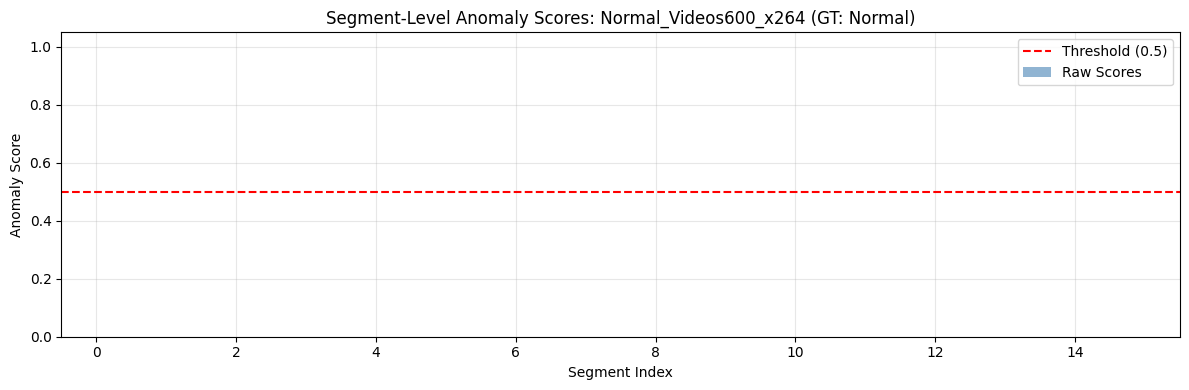


[2] Fighting036_x264


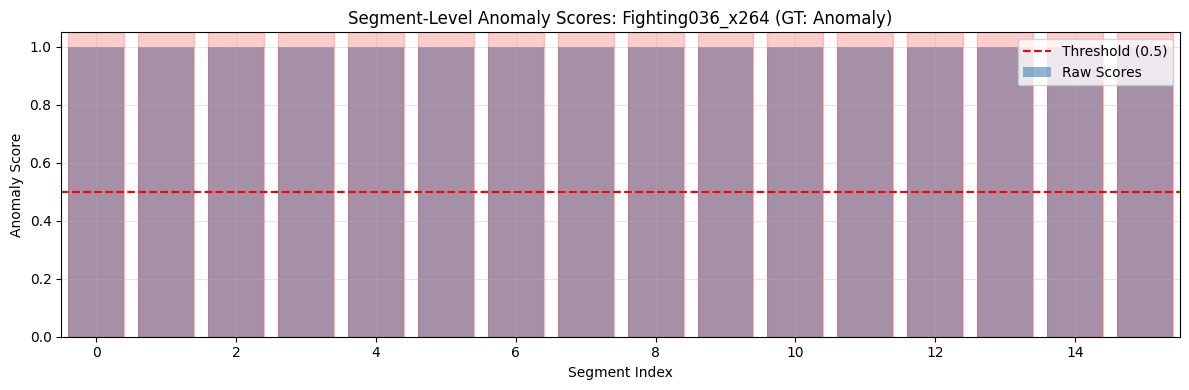


[3] Normal_Videos585_x264


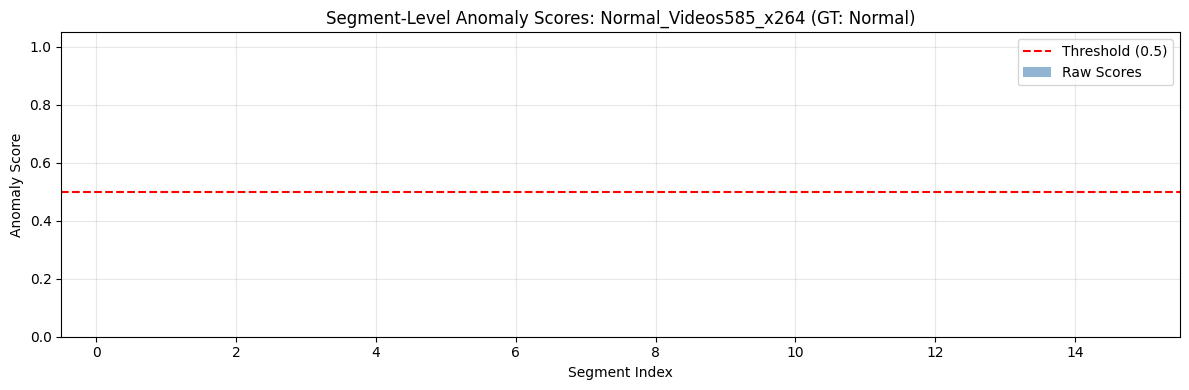


[4] Normal_Videos664_x264


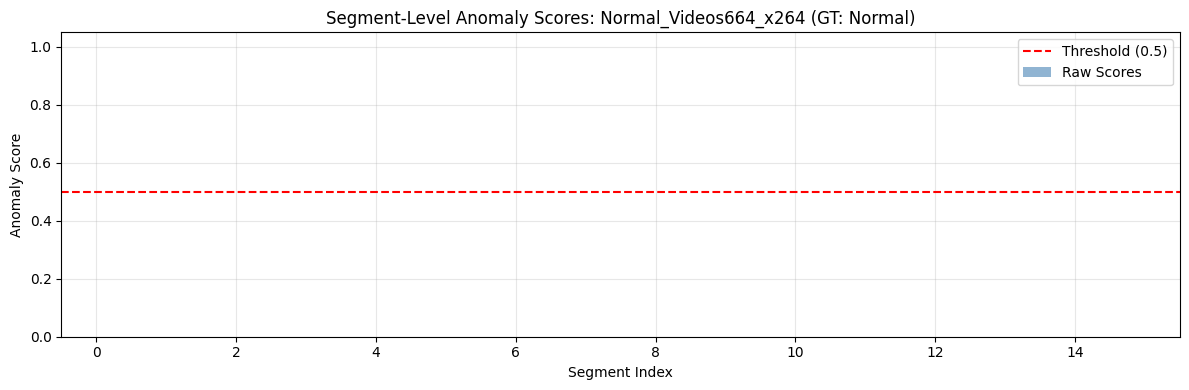

In [9]:
"""
Visualize Sample Results
"""

# Visualize segment scores for a few samples
print("\n" + "="*70)
print("VISUALIZING SAMPLE PREDICTIONS")
print("="*70)

for i, result in enumerate(sample_results[:4]):
    print(f"\n[{i+1}] {result['video_name']}")
    plot_segment_scores(
        segment_scores=np.array(result['segment_scores']),
        smoothed_scores=None,  # Will compute from raw scores
        threshold=ANOMALY_THRESHOLD,
        video_name=result['video_name'],
        ground_truth=result['ground_truth']
    )

## Section 6: Batch Inference and Statistics

In [10]:
"""
Run Full Batch Inference and Calculate Statistics
"""

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report
)

def run_full_inference(
    detector: AnomalyDetector,
    features: np.ndarray,
    labels: np.ndarray,
    video_names: List[str]
) -> Dict:
    """
    Run inference on all videos and calculate comprehensive metrics.
    """
    print("\n" + "="*70)
    print("RUNNING FULL INFERENCE")
    print("="*70)
    
    all_results = []
    all_scores = []
    all_predictions = []
    
    for i, (feat, label, name) in enumerate(tqdm(
        zip(features, labels, video_names),
        total=len(features),
        desc="Processing videos"
    )):
        result = detector.predict(feat)
        result['video_name'] = name
        result['ground_truth'] = int(label)
        
        all_results.append(result)
        all_scores.append(result['video_score'])
        all_predictions.append(int(result['is_anomaly']))
    
    # Convert to arrays
    all_scores = np.array(all_scores)
    all_predictions = np.array(all_predictions)
    
    # Calculate metrics
    metrics = {
        'auc_roc': roc_auc_score(labels, all_scores),
        'accuracy': accuracy_score(labels, all_predictions),
        'precision': precision_score(labels, all_predictions, zero_division=0),
        'recall': recall_score(labels, all_predictions, zero_division=0),
        'f1_score': f1_score(labels, all_predictions, zero_division=0),
        'confusion_matrix': confusion_matrix(labels, all_predictions).tolist(),
        'total_videos': len(labels),
        'detected_anomalies': int(all_predictions.sum()),
        'actual_anomalies': int(labels.sum())
    }
    
    print(f"\n📊 INFERENCE METRICS")
    print(f"   AUC-ROC: {metrics['auc_roc']:.4f}")
    print(f"   Accuracy: {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall: {metrics['recall']:.4f}")
    print(f"   F1-Score: {metrics['f1_score']:.4f}")
    print(f"\n📋 Detection Summary:")
    print(f"   Total Videos: {metrics['total_videos']}")
    print(f"   Actual Anomalies: {metrics['actual_anomalies']}")
    print(f"   Detected Anomalies: {metrics['detected_anomalies']}")
    
    print(f"\n📝 Classification Report:")
    print(classification_report(labels, all_predictions, target_names=['Normal', 'Anomaly']))
    
    print("="*70)
    
    return {
        'results': all_results,
        'scores': all_scores,
        'predictions': all_predictions,
        'metrics': metrics
    }


# Run full inference
full_results = run_full_inference(detector, all_features, all_labels, video_names)


RUNNING FULL INFERENCE


Processing videos:   0%|          | 0/1900 [00:00<?, ?it/s]


📊 INFERENCE METRICS
   AUC-ROC: 0.9893
   Accuracy: 0.9226
   Precision: 0.9926
   Recall: 0.8516
   F1-Score: 0.9167

📋 Detection Summary:
   Total Videos: 1900
   Actual Anomalies: 950
   Detected Anomalies: 815

📝 Classification Report:
              precision    recall  f1-score   support

      Normal       0.87      0.99      0.93       950
     Anomaly       0.99      0.85      0.92       950

    accuracy                           0.92      1900
   macro avg       0.93      0.92      0.92      1900
weighted avg       0.93      0.92      0.92      1900



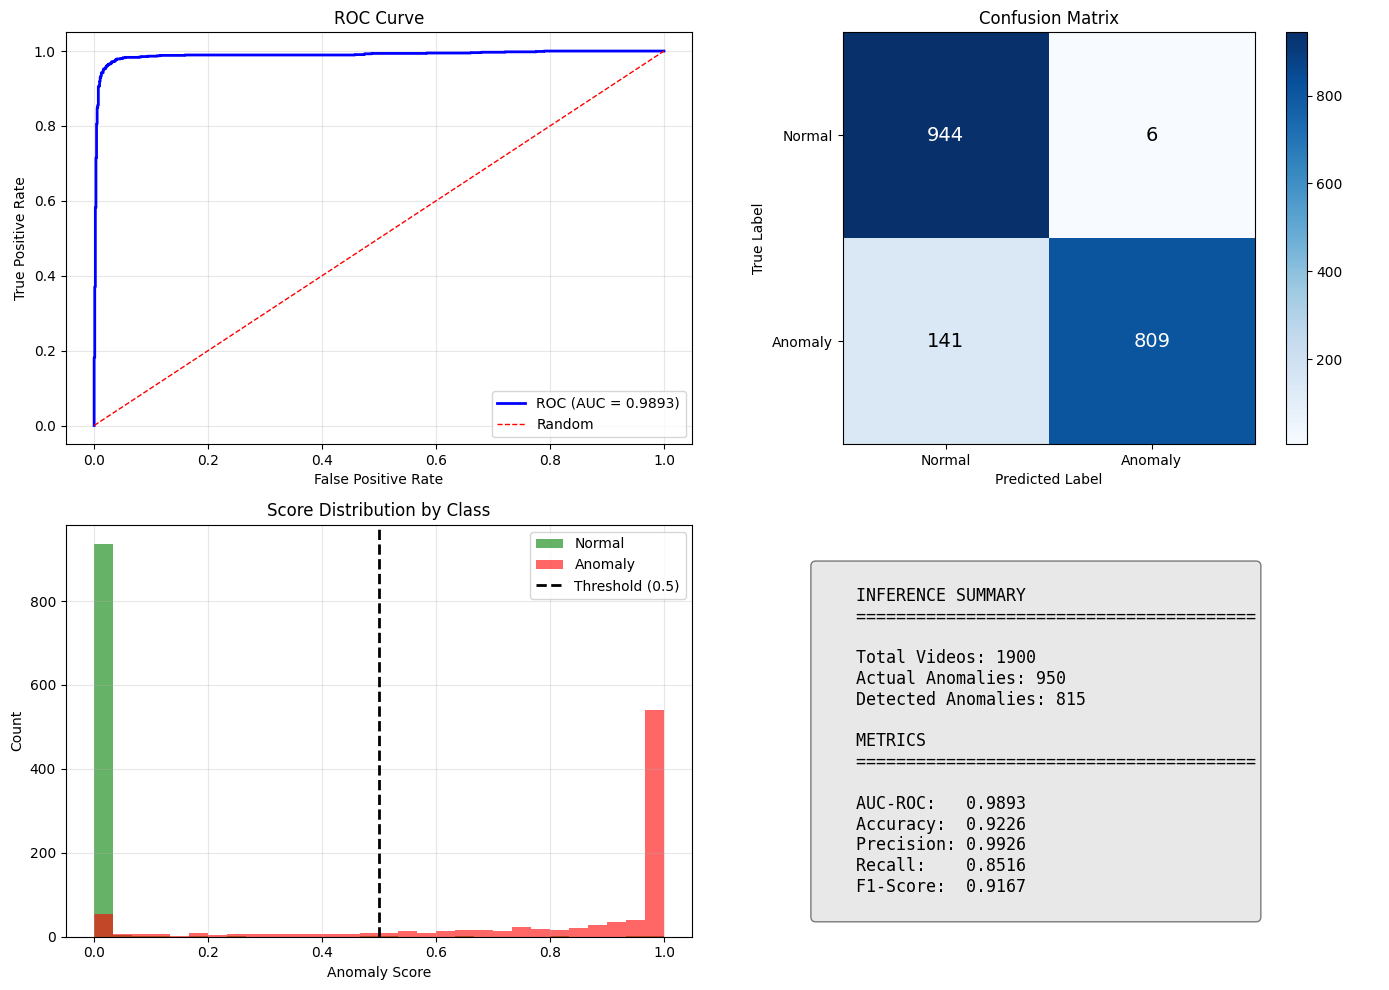


✓ Results saved to: C:\UCF_video_dataset\Inference_Results


In [11]:
"""
Visualize Full Inference Results
"""

from sklearn.metrics import roc_curve

def plot_inference_results(full_results: Dict, labels: np.ndarray):
    """
    Plot comprehensive inference results.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    scores = full_results['scores']
    predictions = full_results['predictions']
    metrics = full_results['metrics']
    
    # 1. ROC Curve
    ax = axes[0, 0]
    fpr, tpr, _ = roc_curve(labels, scores)
    ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {metrics["auc_roc"]:.4f})')
    ax.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    # 2. Confusion Matrix
    ax = axes[0, 1]
    cm = np.array(metrics['confusion_matrix'])
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix')
    plt.colorbar(im, ax=ax)
    
    classes = ['Normal', 'Anomaly']
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=14)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    # 3. Score Distribution
    ax = axes[1, 0]
    anomaly_scores = scores[labels == 1]
    normal_scores = scores[labels == 0]
    
    ax.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='green')
    ax.hist(anomaly_scores, bins=30, alpha=0.6, label='Anomaly', color='red')
    ax.axvline(x=ANOMALY_THRESHOLD, color='black', linestyle='--', linewidth=2, label=f'Threshold ({ANOMALY_THRESHOLD})')
    ax.set_xlabel('Anomaly Score')
    ax.set_ylabel('Count')
    ax.set_title('Score Distribution by Class')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Metrics Summary
    ax = axes[1, 1]
    ax.axis('off')
    
    metrics_text = f"""
    INFERENCE SUMMARY
    {'='*40}
    
    Total Videos: {metrics['total_videos']}
    Actual Anomalies: {metrics['actual_anomalies']}
    Detected Anomalies: {metrics['detected_anomalies']}
    
    METRICS
    {'='*40}
    
    AUC-ROC:   {metrics['auc_roc']:.4f}
    Accuracy:  {metrics['accuracy']:.4f}
    Precision: {metrics['precision']:.4f}
    Recall:    {metrics['recall']:.4f}
    F1-Score:  {metrics['f1_score']:.4f}
    """
    ax.text(0.1, 0.9, metrics_text, transform=ax.transAxes,
           fontsize=12, verticalalignment='top', fontfamily='monospace',
           bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(os.path.join(INFERENCE_OUTPUT_PATH, 'inference_results.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Results saved to: {INFERENCE_OUTPUT_PATH}")


# Plot results
plot_inference_results(full_results, all_labels)

## Section 7: Export Results

In [12]:
"""
Export Inference Results
"""

def export_results(
    full_results: Dict,
    output_path: str = INFERENCE_OUTPUT_PATH
):
    """
    Export inference results to files.
    """
    print("\n" + "="*70)
    print("EXPORTING RESULTS")
    print("="*70)
    
    # 1. Save metrics
    metrics_path = os.path.join(output_path, 'inference_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(full_results['metrics'], f, indent=2)
    print(f"   ✓ Metrics saved: {metrics_path}")
    
    # 2. Save detailed results
    results_path = os.path.join(output_path, 'detailed_results.json')
    serializable_results = []
    for r in full_results['results']:
        result_copy = r.copy()
        # Convert numpy arrays to lists for JSON serialization
        for key in result_copy:
            if isinstance(result_copy[key], np.ndarray):
                result_copy[key] = result_copy[key].tolist()
        serializable_results.append(result_copy)
    
    with open(results_path, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"   ✓ Detailed results saved: {results_path}")
    
    # 3. Save scores as numpy
    scores_path = os.path.join(output_path, 'inference_scores.npz')
    np.savez(scores_path,
             video_scores=full_results['scores'],
             predictions=full_results['predictions'])
    print(f"   ✓ Scores saved: {scores_path}")
    
    # 4. Create summary CSV
    import csv
    csv_path = os.path.join(output_path, 'inference_summary.csv')
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['video_name', 'ground_truth', 'prediction', 'score', 'is_correct'])
        for r in full_results['results']:
            gt = 'Anomaly' if r['ground_truth'] == 1 else 'Normal'
            pred = 'Anomaly' if r['is_anomaly'] else 'Normal'
            is_correct = gt == pred
            writer.writerow([r['video_name'], gt, pred, r['video_score'], is_correct])
    print(f"   ✓ Summary CSV saved: {csv_path}")
    
    print("\n" + "="*70)
    print(f"All results exported to: {output_path}")
    print("="*70)


# Export results
export_results(full_results)


EXPORTING RESULTS
   ✓ Metrics saved: C:\UCF_video_dataset\Inference_Results\inference_metrics.json
   ✓ Detailed results saved: C:\UCF_video_dataset\Inference_Results\detailed_results.json
   ✓ Scores saved: C:\UCF_video_dataset\Inference_Results\inference_scores.npz
   ✓ Summary CSV saved: C:\UCF_video_dataset\Inference_Results\inference_summary.csv

All results exported to: C:\UCF_video_dataset\Inference_Results


## Section 8: Single Video Inference Function

Utility function for inferring on a single new video.

In [13]:
"""
Single Video Inference - Ready for Deployment
"""

def infer_single_video(
    video_features: np.ndarray,
    video_name: str = "Unknown",
    total_frames: int = None,
    visualize: bool = True
) -> Dict:
    """
    Run inference on a single video's features.
    
    Args:
        video_features: Pre-extracted TimeSformer features
        video_name: Name of the video for display
        total_frames: Total frames in video (for frame-level mapping)
        visualize: Whether to show visualization
        
    Returns:
        Complete inference results
    """
    print(f"\n🔍 Processing: {video_name}")
    print("-" * 50)
    
    # Run inference
    result = detector.predict(video_features)
    
    # Print results
    print(f"\n📊 Results:")
    print(f"   Video Score: {result['video_score']:.4f}")
    print(f"   Classification: {'🚨 ANOMALY' if result['is_anomaly'] else '✅ NORMAL'}")
    print(f"   Max Segment Score: {result['max_segment_score']:.4f}")
    print(f"   Anomalous Segments: {result['anomaly_segments']}")
    
    # Get frame-level scores if total_frames provided
    if total_frames:
        frame_scores = detector.get_frame_level_scores(
            np.array(result['smoothed_scores']),
            total_frames
        )
        result['frame_scores'] = frame_scores.tolist()
    
    # Visualize
    if visualize:
        plot_segment_scores(
            segment_scores=np.array(result['segment_scores']),
            smoothed_scores=np.array(result['smoothed_scores']),
            threshold=ANOMALY_THRESHOLD,
            video_name=video_name
        )
        
        if total_frames:
            plot_frame_level_scores(
                frame_scores=np.array(result['frame_scores']),
                threshold=ANOMALY_THRESHOLD,
                video_name=video_name
            )
    
    return result


print("✓ Single video inference function ready!")
print("\n📝 Usage:")
print("   result = infer_single_video(features, 'my_video.mp4', total_frames=1000)")

✓ Single video inference function ready!

📝 Usage:
   result = infer_single_video(features, 'my_video.mp4', total_frames=1000)



🎬 Demo Video: Stealing057_x264
   Ground Truth: Anomaly

🔍 Processing: Stealing057_x264
--------------------------------------------------

📊 Results:
   Video Score: 0.9643
   Classification: 🚨 ANOMALY
   Max Segment Score: 0.9643
   Anomalous Segments: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


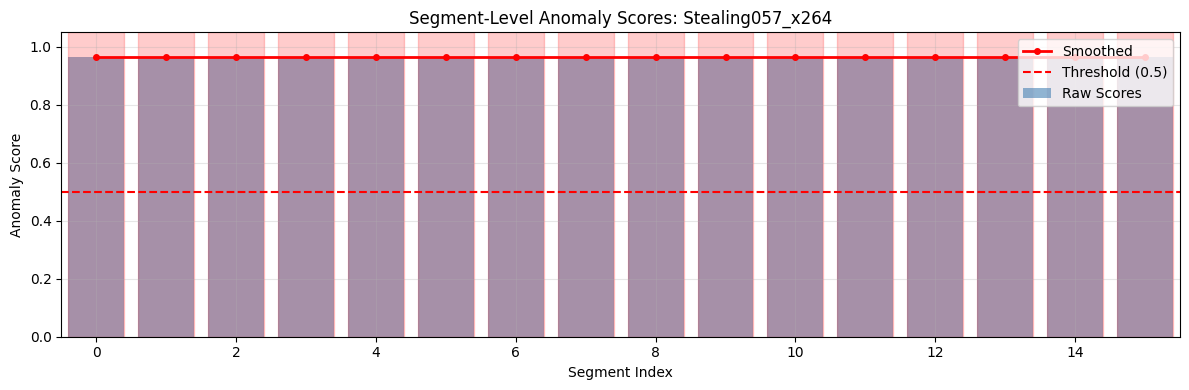

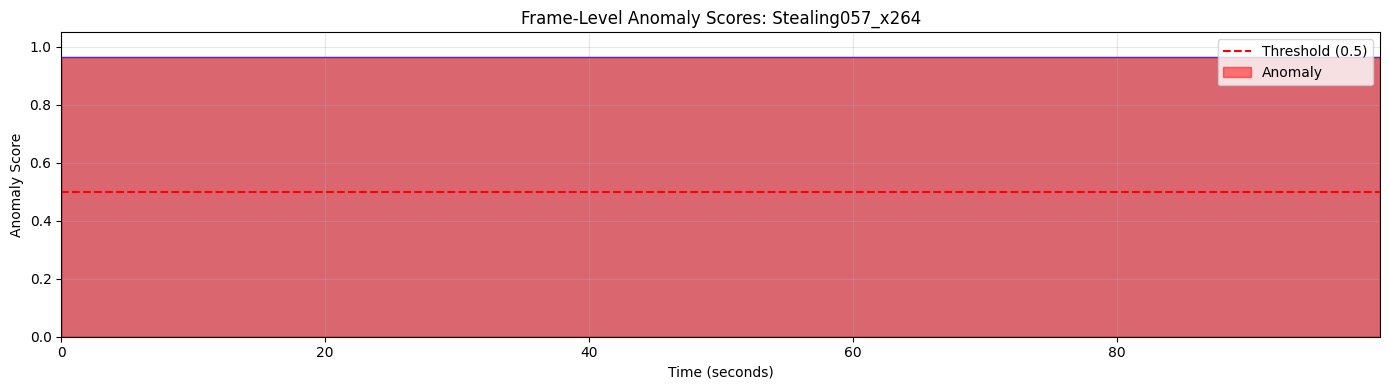

In [14]:
"""
Demo: Infer on a Single Test Video
"""

# Select a random test video
demo_idx = np.random.randint(0, len(all_features))
demo_features = all_features[demo_idx]
demo_name = video_names[demo_idx]
demo_gt = "Anomaly" if all_labels[demo_idx] == 1 else "Normal"

print(f"\n🎬 Demo Video: {demo_name}")
print(f"   Ground Truth: {demo_gt}")

# Run inference
demo_result = infer_single_video(
    video_features=demo_features,
    video_name=demo_name,
    total_frames=3000,  # Assume 100 seconds at 30fps
    visualize=True
)

## Section 9: Summary and Next Steps

In [15]:
print("\n" + "="*70)
print("PHASE 4 COMPLETE: INFERENCE & DEPLOYMENT")
print("="*70)
print("""
✅ What was accomplished:
   1. Loaded trained MIL model from Phase 3
   2. Created AnomalyDetector class for inference
   3. Ran inference on all test videos
   4. Generated segment-level and frame-level scores
   5. Created visualizations for anomaly detection
   6. Exported results for analysis

📁 Output Files:
   Inference_Results/
   ├── inference_metrics.json     (Performance metrics)
   ├── detailed_results.json      (Per-video predictions)
   ├── inference_scores.npz       (Numpy arrays)
   ├── inference_summary.csv      (Summary table)
   └── inference_results.png      (Visualization)

🚀 Deployment Ready:
   - Use `infer_single_video()` for new videos
   - Use `detector.predict()` for batch processing
   - Use `detector.get_frame_level_scores()` for temporal localization

📋 Next Steps for Production:
   1. Integrate with video processing pipeline
   2. Add real-time streaming support
   3. Create REST API for deployment
   4. Add alerting system for anomaly detection
   5. Optimize for edge deployment (ONNX, TensorRT)
""")
print("="*70)

# Final metrics summary
print(f"\n📊 Final Inference Metrics:")
print(f"   AUC-ROC: {full_results['metrics']['auc_roc']:.4f}")
print(f"   Accuracy: {full_results['metrics']['accuracy']:.4f}")
print(f"   F1-Score: {full_results['metrics']['f1_score']:.4f}")


PHASE 4 COMPLETE: INFERENCE & DEPLOYMENT

✅ What was accomplished:
   1. Loaded trained MIL model from Phase 3
   2. Created AnomalyDetector class for inference
   3. Ran inference on all test videos
   4. Generated segment-level and frame-level scores
   5. Created visualizations for anomaly detection
   6. Exported results for analysis

📁 Output Files:
   Inference_Results/
   ├── inference_metrics.json     (Performance metrics)
   ├── detailed_results.json      (Per-video predictions)
   ├── inference_scores.npz       (Numpy arrays)
   ├── inference_summary.csv      (Summary table)
   └── inference_results.png      (Visualization)

🚀 Deployment Ready:
   - Use `infer_single_video()` for new videos
   - Use `detector.predict()` for batch processing
   - Use `detector.get_frame_level_scores()` for temporal localization

📋 Next Steps for Production:
   1. Integrate with video processing pipeline
   2. Add real-time streaming support
   3. Create REST API for deployment
   4. Add alert